Aggregation, Filtering and Dispersion Tests
==

Decaying Tracer
--

The tuning process is going to attempt to capture spring-neap variability, and so we need
a more continuous-in-time metric of how the dispersion compares.  This notebook
develops tests where decaying tracers are input to the system, and then we can 
compare, over time and space, the fidelity of each model relative to the original.


In [ ]:
# Quiet some of the logging
# workaround via specifying an invalid value first
%config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='INFO'
import logging
logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger()
log.debug('Test debug')
log.info('Test info')
log.warning('Test warn')

In [152]:
import matplotlib.pyplot as plt
from matplotlib import colors
from shapely import geometry, wkt
import stompy.plot.cmap as scmap
import xarray as xr
from stompy.grid import unstructured_grid
import numpy as np
import pandas as pd
import stompy.model.delft.waq_scenario as dwaq
import logging as log
from stompy import utils
from stompy.plot import plot_wkb
import netCDF4
import warnings
from stompy.model.data_comparison import calc_metrics
import os
import six
from matplotlib import gridspec
%matplotlib inline

In [319]:
import tracer_common as tc
six.moves.reload_module(tc)

<module 'tracer_common' from '/hpcvol1/rusty/dwaq/agg_wy2013/tracer_tests/tracer_common.py'>

In [153]:
cmap=scmap.load_gradient('turbo.cpt') # a less offensive 'jet'

In [155]:
# configure DWAQ:
DELFT_SRC="/home/alliek/software/Delft3D-FM/64634"
DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
DELFT_LIB=os.path.join(DELFT_SRC,"lib")

os.environ['DELFT_SRC']=DELFT_SRC
os.environ['DELFT_SHARE']=DELFT_SHARE
# not great - really should check what's already in there.
os.environ['LD_LIBRARY_PATH']=DELFT_LIB

In [156]:
# Narrowed down to just the two runs that we've actually been using
hydro_orig=dwaq.HydroFiles("/hpcvol1/public/sfb_dfm_v2/wy2013c/DFM_DELWAQ_wy2013c_adj/wy2013c.hyd")
hydro_orig.name='orig'
hydro_agg141_lp=dwaq.HydroFiles("../../agg141-lp/com-wy2013c-agg141-lp.hyd")
hydro_agg141_lp.name='agg141_lp'

In [157]:
hydro_agg141=dwaq.HydroFiles("../../agg141/com-wy2013c-agg141.hyd")
hydro_agg141.name='agg141'

In [280]:
class CommonSetup(object):
    """
    Common code for various tracers runs
    """
    name='common' # should overload
    hydro=None
    base_path=None # must be set!

    force=False # whether to allow re-using an existing run
    
    # start time offset from start of hydro by this delta
    # give it some decent spinup time
    start_offset=np.timedelta64(75,'D')
    # set length of the run
    duration=np.timedelta64(5,'D')

    base_x_dispersion=0.0 # will be copied to the WaqModel
    # tried 22.60, but got some bad behavior with age tracers.
    # try reverting..
    integration_option="15.60" # if set, copied to WaqModel
    time_step=3000
    map_time_step=3000 # otherwise it will default to time_step, which could be really short.
    
    scale_v_disp=1.0
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)   
        if self.base_path is None:
            self.base_path=self.calc_base_path()
                
            if self.start_offset!=np.timedelta64(75,'D'):
                # yuck.  dates.
                yyyymmdd=utils.to_datetime(utils.to_dt64(self.hydro.t_dn[0])+self.start_offset).strftime('%Y%m%d')
                self.base_path+="_%s"%(yyyymmdd)
    
            log.info("base_path defaults to %s"%self.base_path)
    def calc_base_path(self):
        p='run_%s_%s'%(self.hydro.name,self.name)
        if self.base_x_dispersion!=0.0:
            p+="_Kx%g"%self.base_x_dispersion
        if self.scale_v_disp!=1.0:
            p+="_Kz%g"%self.scale_v_disp
        return p
    
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_summary()
        return self # makes for more compact iteration loops later
        
    def release_conc_2d(self,X0,L):
        grid=self.hydro.grid()
        X=grid.cells_centroid()
        
        c=np.exp( -((X-X0)**2).sum(axis=-1)/L**2 )
        c=c/c.max() # make max value 1
        return c
    
    def release_conc_3d(self,X0,L):
        C_2d=self.release_conc_2d(X0,L)
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def setup_model(self):
        # Create a WaqModel, add some tracers
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path,
                                 mon_time_step=1000000, # daily
                                 base_x_dispersion=self.base_x_dispersion,
                                 time_step=self.time_step)
        # add some option for balances.
        wm.integration_option="%s BALANCES-OLD-STYLE BAL_NOLUMPPROCESSES BAL_NOLUMPLOADS BAL_NOLUMPTRANSPORT"%self.integration_option
        wm.start_time+= self.start_offset
        wm.stop_time=wm.start_time + self.duration

        self.setup_tracers()
        
        wm.parameters['ACTIVE_VertDisp']=1
        wm.parameters['ScaleVDisp']=self.scale_v_disp # probably needs to be <1
    
    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path,load_hydro=False)
                return

        self.setup_model()
        
        wm=self.wm
        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.cmd_write_nc()
    
    def setup_tracer_continuity(self):
        # continuity tracer:
        self.wm.substances['continuity']=dwaq.Substance(initial=1.0)
        # This adds a concentration=1.0 boundary condition on all the boundaries.
        all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]
        self.wm.add_bc(all_bcs,'continuity',1.0)
    
        
    
class Blobber(CommonSetup):
        
    # plume parameters
    X0=np.array([567500,4.16795e6])
    L=5000
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    name='gaussian' # used to form default base_path
    
    def calc_base_path(self):
        base=super(Blobber,self).calc_base_path()
        details=""
        if self.base_x_dispersion!=0.0:
            base+="_Kx%g"%self.base_x_dispersion
        if self.integration_option!="15.60":
            base+="_int%s"%self.integration_option
        if self.duration!=np.timedelta64(5,'D'):
            ndays=int(self.duration/np.timedelta64(1,'D'))
            base+="_%ddays"%ndays
        return base
    def setup_tracers(self):
        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d(X0=self.X0,L=self.L)
        self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)
        self.setup_tracer_continuity()
    
    def figure_summary(self):
        ds=xr.open_dataset(os.path.join(self.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(1,3,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        # continuity
        ax=axs[2]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Continuity",transform=ax.transAxes,va='top')
        coll_cont=grid_ds.plot_cells(values=ds['continuity'].isel(time=-1,layer=0),ax=ax,cmap='seismic',
                                     clim=[0.8,1.2])

        for coll in [coll_ic,coll_ec,coll_cont]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion
            
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.

class BlobLSB(Blobber):
    """
    minor adjustment to put a blob in LSB
    """
    X0=np.array([582019,4.14719e6])
    L=5000
    blob_name='lsb_gaussian'
    #zoom=(552164., 595434., 4138443.,4186236.)

Continuous Release
==

Unlike the tests above, here the tracer source is a point with a continuous
mass-per-time discharge. So far it runs, but no analysis yet. One avenue
for analysis is to run release for 15-25 days, and compare the spatial
distribution of the resulting plumes. For qualitative comparison that's
straightforward. To get quantitative, it may be most appropriate to 
average the output from the original grid onto the aggregated grid, then
evaluate how close the two sets of concentrations are.

In [281]:
def recalc_age(cons,decay,rate=0.01,min_cons=1e-7):
    # There are some numerical issues with the age tracers, notably
    # that in some cases the decaying tracer is greater than the
    # conservative tracer.
    # recalculate age to have a better sense of where
    # the nan's are.
    # the rate here is the default in dwaq, with units of day-1
    
    # possible for cons or decay to be nan, 0, or for cons<decay,
    # all of which are problematic.
    with np.errstate(invalid='ignore',divide='ignore'):
        valid=(cons>1e-7)
        my_age=np.log(decay/cons) / np.log(1-rate)
        my_age[ cons<min_cons]=np.nan
        my_age[ decay>cons]=0.0
        my_age[np.isnan(cons*decay)]=np.nan 
    return my_age

class DecayingPlume(CommonSetup):
    """
    A continuous source of decaying tracer.
    """
    # set length of the run -- for continuous release go for longer duration
    # figure 20 days spinup, and 60 days to get two months (two big spring, two
    # small spring, etc.).
    # but it looks like it wasn't fully spunup at that point.
    # so go for an even 200 days.  the runs are starting at 2012-10-15.
    # there is a significant delta flow event Dec 29 or so.
    # this will run through 2013-02-02.
    duration=np.timedelta64(110,'D')
    name='tripleDecay' 
            
    # source parameters
    X0=np.array([ # [567500,4.16795e6], # middle of S Bay
                  [571931,4165989], # S Bay E shoal, just north of SMB
                  [560611,4165243], # S Bay channel, off SFO
                  [581860,4148149]  # LSB, near CM17
     ])
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    decay_rate=0.01 # for WAQ decay process 
    
    tracer_clim=[0,0.5]
    age_clim=[0,60]
    
    def setup_tracers(self):
        # boundary condition will default to 0.0
        for i,x0 in enumerate(self.X0):
            ctr="cTr%d"%(1+i)
            dtr="dTr%d"%(1+i)
            proc="ACTIVE_Age%d"%(1+i)
            self.wm.parameters['RcDecTR%d'%(1+i)]=self.decay_rate
            
            self.wm.substances[ctr]=dwaq.Substance(initial=0.0)
            self.wm.substances[dtr]=dwaq.Substance(initial=0.0)
            elt=self.hydro.grid().select_cells_nearest(x0)
            discharge=self.wm.add_discharge(element=elt,k=0)
            self.wm.add_load([discharge],[ctr,dtr],100.0)
            # Somehow, DWAQ is coming up with dTr1 values greater than cTr1
            # in some cases.  Maybe related to the integration scheme.
            # Even though I don't use the Age output, I'm keeping the process
            # on as a way to make sure that decay is turned on.  It should be
            # possible to directly turn decay on, and not calculate age.
            # no big difference...
            self.wm.parameters[proc]=1
            # I think it's actually possible to have 5, but only 3 age
            # tracers. And there are probably some other decaying processes
            # that could be co-opted if necessary.
            assert i<5,"Only 5 decay tracers allowed"
        # I'm going to recalculate my own age, so no need to output it.
        #self.wm.map_output = self.wm.map_output + ('AgeTr1',)

    def figure_summary(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(3,len(self.X0),squeeze=False,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,4*len(self.X0)],
                            forward=True)

        for i,x0 in enumerate(self.X0):
            ctr="cTr%d"%(1+i)
            dtr="dTr%d"%(1+i)
            con_vals=ds[ctr].isel(time=-1,layer=0).values
            dec_vals=ds[dtr].isel(time=-1,layer=0).values
            age_vals=recalc_age(con_vals,dec_vals,rate=self.decay_rate)
            
            # at the end 
            axs[0,i].text(self.txt_loc[0],self.txt_loc[1],"Conservative",transform=axs[0,i].transAxes,va='top')
            coll_con=grid_ds.plot_cells(values=con_vals,ax=axs[0,i],cmap=cmap)
            coll_con.set_clim(self.tracer_clim)

            axs[1,i].text(self.txt_loc[0],self.txt_loc[1],"Decaying",transform=axs[1,i].transAxes,va='top')
            coll_dec=grid_ds.plot_cells(values=dec_vals,ax=axs[1,i],cmap=cmap)
            coll_dec.set_clim(self.tracer_clim)

            axs[2,i].text(self.txt_loc[0],self.txt_loc[1],"Age",transform=axs[2,i].transAxes,va='top')
            coll_age=grid_ds.plot_cells(values=age_vals,ax=axs[2,i],cmap=cmap)
            coll_age.set_clim(self.age_clim)
            
            for coll in [coll_con,coll_dec,coll_age]:
                coll.set_lw(0.75)
                coll.set_edgecolor('face')
                
            for ax in axs[:,i]:
                ax.plot([x0[0]],[x0[1]],marker='o',color='yellow',ms=8,mew=1.,mec='k')
            
        for ax in axs.ravel():
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion
            
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
    

In [19]:
runs=[]
for hydro in [hydro_agg141_lp,
              hydro_orig # Takes a while.
             ]:
    run=DecayingPlume(hydro=hydro,force=False)
    run.run_waq_model()
    runs.append( run )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_orig_tripleDecay
INFO:root:Run seems to exist -- will not run again


In [20]:
# Aggregate output from the original run to the time and spatial scales of the agg
# run for evaluation of the dispersion coefficients.
agg_run=runs[0]
orig_run=runs[1]

# Get the aggregated geometry:
agg_grid=agg_run.hydro.grid()

# The data to be aggregated
orig_map_ds=orig_run.wm.map_ds()

In [21]:
# pretty slow. maybe 2 minutes?
from stompy.memoize import memoize

@memoize
def agger():
    return dwaq.HydroAggregator(hydro_orig,agg_shp=agg_grid)


In [22]:
def agg_decay_tracers(model,force=False):
    def reckless_nanmean(*a,**kw):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return np.nanmean(*a,**kw)
    
    # pre-calculated the data on the original grid, 
    # aggregate, write to netcdf.
    precalc_fn=os.path.join(model.base_path,'decay_summary_v00.nc')
    
    age_orig_agg2ds=[]

    if os.path.exists(precalc_fn) and force:
        os.unlink(precalc_fn)
        
    if not os.path.exists(precalc_fn):
        model_grid=model.load_hydro().grid()
        
        if ( (agg_grid.Ncells()==model_grid.Ncells()) and
             (np.allclose( model_grid.cells_centroid(),
                           agg_grid.cells_centroid() )) ):
            needs_aggregation=False 
        else:
            needs_aggregation=True
            
        orig_map_ds=model.map_ds()
        layers=orig_map_ds.dims['layer']
        
        # These could get large -- try to build it iteratively.
        ds=xr.Dataset()
        ds['time']=orig_map_ds['time']
        ds['t_sec']=orig_map_ds['t_sec']
        agg_grid.write_to_xarray(ds)
        ds.to_netcdf(precalc_fn)
        ds.close()
        
        nc=netCDF4.Dataset(precalc_fn,mode='r+')
        
        for tracer in range(5): # max number of decay tracers
            cTr="cTr%d"%(tracer+1)
            dTr="dTr%d"%(tracer+1)
            if cTr not in orig_map_ds:
                break
            log.info("%s: Processing tracers %s, %s"%(precalc_fn,cTr,dTr))
            
            nc_var=nc.createVariable('age%d'%(tracer+1),np.float32,('time','face'),
                                     zlib=True,complevel=2)
            
            for t_idx in utils.progress(range(orig_map_ds.dims['time'])):
                t_sec=orig_map_ds['t_sec'].isel(time=t_idx).values
                age_orig=recalc_age(orig_map_ds[cTr].isel(time=t_idx).values,
                                    orig_map_ds[dTr].isel(time=t_idx).values )
                # then aggregate but avoid nan contamination
                if needs_aggregation:
                    age_orig_agg3d=agger().segment_aggregator(t_sec,age_orig.ravel(),nan_method='ignore')
                    age_orig_agg2d=reckless_nanmean( age_orig_agg3d.reshape((layers,-1)),axis=0)
                else:
                    age_orig_agg2d=reckless_nanmean(age_orig, axis=0)
                nc_var[t_idx,:]=age_orig_agg2d
            nc.sync()
        nc.close()
        
    return xr.open_dataset(precalc_fn)
    
orig_tracers=agg_decay_tracers(orig_run.wm,force=False)
agg_tracers= agg_decay_tracers(agg_run.wm,force=False)

In [ ]:
for tr in range(3):
    fig,axs=plt.subplots(1,2,figsize=(14,7))
    for ax,tracers in zip(axs,[orig_tracers,agg_tracers]):
        agg_grid.plot_cells(values=tracers['age%d'%(1+tr)].isel(time=-1),
                            cmap=cmap,clim=[0,40],ax=ax)
        ax.axis(DecayingPlume.zoom) 
        ax.axis('off') 

In [23]:
# Parameters controlling the calculation of skill metrics
cell_sel=agg_grid.cell_clip_mask(DecayingPlume.zoom) # limit to the cells in South Bay
# start at 1500 for spinup allowance.
# note that the run doesn't appear to be fully spunup
# even by 80 days, but hopefully most of the remaining
# spinup is outside south bay 
t_slc=slice(1500,-1,100)
ages=['age1','age2','age3']

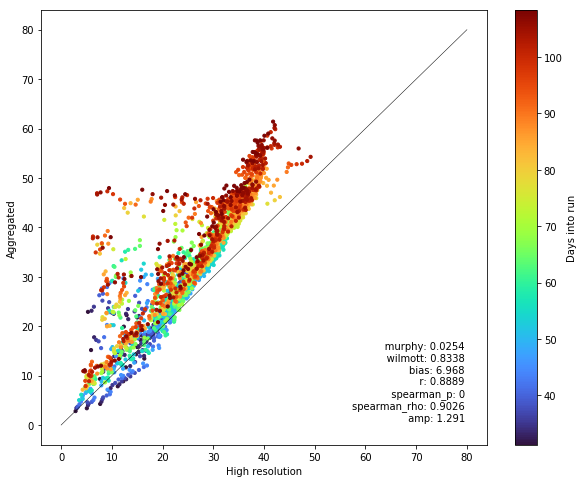

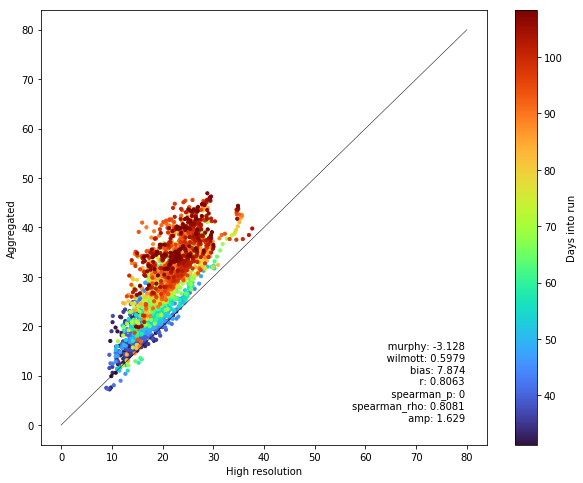

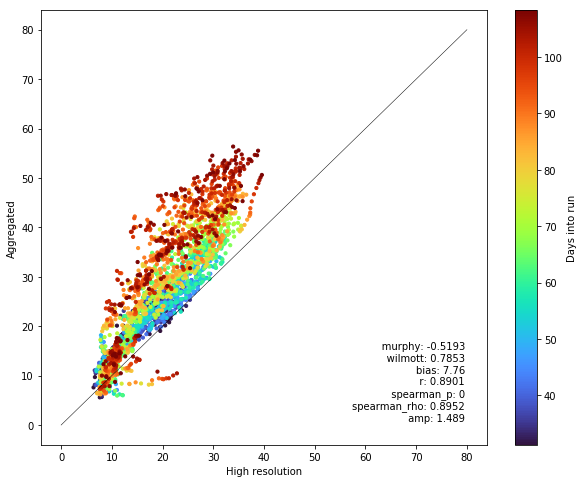

In [24]:
for age in ages:
    orig_ages=orig_tracers[age].isel(time=t_slc,face=cell_sel)
    t_secs=orig_tracers.t_sec.isel(time=t_slc)

    orig_ages,t_secs=xr.broadcast(orig_ages,t_secs)

    agg_ages=agg_tracers[age].isel(time=t_slc,face=cell_sel)
    fig,ax=plt.subplots(figsize=(10,8))
    
    t_days=(t_secs.values-orig_tracers.t_sec.values[0])/86400.

    scat=ax.scatter(orig_ages.values.ravel(),agg_ages.values.ravel(),
                    10,t_days.ravel(),cmap=cmap)
    ax.set_xlabel('High resolution')
    ax.set_ylabel('Aggregated')
    plt.colorbar(scat,label='Days into run')
    ax.plot([0,80],[0,80],'k-',lw=0.5)

    metrics=calc_metrics(agg_ages.values.ravel(), orig_ages.values.ravel() )
    text="\n".join([ "%20s: %.4g"%(k,metrics[k]) for k in metrics])
    ax.text(0.95,0.05,text,ha='right',va='bottom',transform=ax.transAxes)


In [40]:
# Wrap up the comparison into one method
def decay_metrics(test_ds,ref_ds):
    """
    test_ds: dataset with age1..agen fields, each with dimensions time,face.
    ref_ds: same, but the "correct" data.
    """
    score_per_age=[]
    
    for age in ages:
        ref_ages=ref_ds[age].isel(time=t_slc,face=cell_sel)
        test_ages=test_ds[age].isel(time=t_slc,face=cell_sel)
        assert np.all( np.isfinite(ref_ages.values))
        assert np.all( np.isfinite(test_ages.values))
        
        #wilmott=utils.model_skill(test_ages.values.ravel(), ref_ages.values.ravel() )
        #score_per_age.append(wilmott)
        test_vals=test_ages.values.ravel()
        metrics=calc_metrics(test_vals, ref_ages.values.ravel())
        metrics['nan_fraction']=np.isnan(test_vals).sum() / float(len(test_vals))
        score_per_age.append(metrics)
    res={}
    for k in score_per_age[0]:
        res[k]=np.mean([ m[k] for m in score_per_age])
    return res

decay_metrics(agg_tracers,orig_tracers)

{'amp': 0.94663328,
 'bias': 0.176172,
 'murphy': 0.86721125990152359,
 'nan_fraction': 0.0,
 'r': 0.94958463604380283,
 'spearman_p': 0.0,
 'spearman_rho': 0.95370878886383148,
 'wilmott': 0.9644587033738693}

In [41]:
# next layer of the onion -- scan parameters with just a spatially/temporally
# constant base_x_dispersion.

rows=[]

for K in [0,50,100,150,200,250,300,400,500,700,1000]:
    run=DecayingPlume(hydro=hydro_agg141_lp,base_x_dispersion=K)
    run.run_waq_model()
    agg_tracers= agg_decay_tracers(run.wm,force=False)
    score = decay_metrics(agg_tracers,orig_tracers)
    score['K']=K
    rows.append( score )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx50
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx100
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx150
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx200
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx250
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx300
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx400
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kx500
INFO:root:Run seems to 

In [321]:
pd.DataFrame(rows)

,K,amp,bias,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0,1.470008,7.533776,-1.207309,0.0,0.861773,0.000000e+00,0.868625,0.738991
1,50,1.188761,3.967516,-0.013398,0.0,0.889577,0.000000e+00,0.894816,0.842721
2,100,1.012720,1.782193,0.420266,0.0,0.868017,0.000000e+00,0.870289,0.870656
3,150,0.877663,-0.022783,0.591759,0.0,0.853052,0.000000e+00,0.853514,0.872856
4,200,0.771011,-1.542986,0.595941,0.0,0.841935,0.000000e+00,0.840933,0.854661
5,250,0.685339,-2.843640,0.494242,0.0,0.832373,0.000000e+00,0.829988,0.821458
6,300,0.615570,-3.971534,0.326530,0.0,0.823066,0.000000e+00,0.818958,0.778579
7,400,0.510254,-5.836282,-0.112464,0.0,0.802748,4.316953e-281,0.795920,0.686635
8,500,0.436062,-7.319726,-0.603770,0.0,0.778734,3.352053e-221,0.768349,0.619841
9,700,0.341649,-9.539895,-1.568190,0.0,0.721093,6.654632e-128,0.702127,0.539211


Scaling Dispersion from Tidal--Nontidal Difference
--

As a halfway point between (a) a direct calculation of what the dispersion 
coefficient "should" be, and (b) prescribing anisotropic dispersion coefficients
through blind optimization, there is a middle ground of correlating
dispersion with features of the hydrodynamics. This section looks at
the feasibility of using the difference between the tidal and non-tidal
advective fluxes as a predictor of dispersion coefficient.

The scaling here is important. Fluxes are m$^3$/s, and dispersion coefficients
are m$^2$/s.

As a thought experiment, consider a case where each tidal cycle
leads to a net exchange of 10% of the volume between two control
volumes of equal size. In a subtidal representation of this system,
that flux is the product of the difference in concentrations, the
area of their common face, and divided by the length between them.

If we assume that the dispersive flux should scale with the rms
tidal flux, then to get the corresponding dispersion coefficient we
scale rms flux by length/area.

Overall, the approach is promising, and with tuning a single
parameter it comes close to performing as well as the Kxy approach
which required 2-3 parameters (and even then, the parameters are
specific to the 3 test regions).

In [282]:
class Kauto(object):
    """
    Variable in space/direction dispersion coefficient. Not quite to the
    real deal, as we really want to include spring/neap variability.
    """
    # choose some period over which to look at the stats
    ti_start=2000
    ti_stop =2200
    hydro_tidal=None # set this to a tidal version of self.hydro
    K_scale=0.02 # non-dimensional scaling from Qexch*L/A => dispersion coefficient.
    
    def calc_base_path(self):
        base_path=super(Kauto,self).calc_base_path()
        base_path+="_Kauto%g"%self.K_scale
        return base_path
    def setup_model(self):
        super(Kauto,self).setup_model()
        Kexch=self.disp_array()
        self.wm.dispersions['anisoK']=dwaq.DispArray(substances=".*",data=Kexch)
        
    def disp_array(self):
        self.hydro.infer_2d_elements()
        self.hydro.infer_2d_links()
        
        K=np.zeros(self.hydro.n_exch,np.float64)

        Qaccum=np.zeros(self.hydro.n_2d_links,np.float64)
        Aaccum=np.zeros(self.hydro.n_2d_links,np.float64)
        accum_count=0

        for ti in range(self.ti_start,self.ti_stop):
            t_sec=hydro.t_secs[ti]
            flows=[ hydro.flows(t_sec) for hydro in [self.hydro_tidal,self.hydro]]
            flow_hp=flows[0] - flows[1]
            # depth-integrate
            flow_hor=flow_hp[:self.hydro_tidal.n_exch_x]
            link_flows=np.bincount( self.hydro.exch_to_2d_link['link'],
                                    self.hydro.exch_to_2d_link['sgn']*flow_hor)
            
            Qaccum+=link_flows**2
            Aaccum+=np.bincount( self.hydro.exch_to_2d_link['link'],self.hydro.areas(t_sec)[:self.hydro.n_exch_x])
            accum_count+=1
        rms_flows=np.sqrt(Qaccum/accum_count)
        mean_A=Aaccum/accum_count
        
        Lexch=self.hydro.exchange_lengths.sum(axis=1)[:self.hydro.n_exch_x]
        L=[Lexch[exchs[0]] for l,exchs in utils.enumerate_groups(self.hydro.exch_to_2d_link['link'])]
        
        # This is just a placeholder. A proper scaling needs to account for 
        # cell size. rms_flows has units of m3/s. probably that should be normalized
        # by dividing by average flux area, and possibly multiplying by the distance
        # between cell centers. that doesn't seem quite right.
        link_K=self.K_scale*rms_flows*L/mean_A
        K[:self.hydro.n_exch_x]=link_K[self.hydro.exch_to_2d_link['link']]
        
        log.info("Median dispersion coefficient: %g"%(np.median(K)))
        return K

class DecayingPlumeKauto(Kauto,DecayingPlume): pass


In [184]:
rows2=[]

for K_scale in [0.0,0.01,0.02,0.05,0.08,0.10,0.12,0.15,0.20]:
    run=DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=K_scale)
    run.run_waq_model()
    agg_tracers= agg_decay_tracers(run.wm,force=False)
    score = decay_metrics(agg_tracers,orig_tracers)
    score['K_scale']=K_scale
    print("K=%g: score=%.4f"%(K_scale,score['wilmott']))
    rows2.append( score )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.01
INFO:root:Run seems to exist -- will not run again


K=0: score=0.7390


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.02
INFO:root:Run seems to exist -- will not run again


K=0.01: score=0.7913


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.05
INFO:root:Run seems to exist -- will not run again


K=0.02: score=0.8302


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.08
INFO:WaqModel: start time updated from hydro: 2012-08-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2013-10-01T00:00:00.000000
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7fd6327082e8>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fd6352f43c8>)])
INFO:root:Median dispersion coefficient: 17.4993
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey boundary-links.csv
INFO:HydroFiles:Writing hyd file
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:HydroFiles:Writing srf file
INFO:HydroFiles:Writing hydro parameters
INFO:InpFile:No velocity arrays, will skip assignment to substances
INFO:WaqModel:Runnin

K=0.05: score=0.9093


INFO:WaqModel:delwaq1 ran in 0.27s
INFO:WaqModel:Running delwaq2 - might take a while...
INFO:WaqModel:  /opt/anaconda3/bin/delwaq2 waqmodel
INFO:WaqModel:Waiting for run_agg141_lp_tripleDecay_Kauto0.08/waqmodel.mon to be created
INFO:WaqModel:Okay - run_agg141_lp_tripleDecay_Kauto0.08/waqmodel.mon exists now
INFO:WaqModel:0.00% Completed
INFO:WaqModel:0.91% Completed
INFO:WaqModel:Time remaining: 0.009h (Wed Dec 18 14:46:51 2019) 284417.41x realtime
INFO:WaqModel:1.82% Completed
INFO:WaqModel:Time remaining: 0.011h (Wed Dec 18 14:46:57 2019) 241516.15x realtime
INFO:WaqModel:2.73% Completed
INFO:WaqModel:Time remaining: 0.011h (Wed Dec 18 14:47:00 2019) 229006.27x realtime
INFO:WaqModel:3.64% Completed
INFO:WaqModel:Time remaining: 0.011h (Wed Dec 18 14:47:01 2019) 223336.26x realtime
INFO:WaqModel:4.55% Completed
INFO:WaqModel:Time remaining: 0.011h (Wed Dec 18 14:47:01 2019) 220255.26x realtime
INFO:WaqModel:5.45% Completed
INFO:WaqModel:Time remaining: 0.011h (Wed Dec 18 14:47:00 2

K=0.08: score=0.9527


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.12
INFO:WaqModel: start time updated from hydro: 2012-08-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2013-10-01T00:00:00.000000
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7fd6325138d0>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fd632551470>)])
INFO:root:Median dispersion coefficient: 26.249
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey boundary-links.csv
INFO:HydroFiles:Writing hyd file
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:HydroFiles:Writing srf file
INFO:HydroFiles:Writing hydro parameters
INFO:InpFile:No velocity arrays, will skip assignment to substances
INFO:WaqModel:Running

K=0.1: score=0.9645


INFO:WaqModel:delwaq1 ran in 0.27s
INFO:WaqModel:Running delwaq2 - might take a while...
INFO:WaqModel:  /opt/anaconda3/bin/delwaq2 waqmodel
INFO:WaqModel:Waiting for run_agg141_lp_tripleDecay_Kauto0.12/waqmodel.mon to be created
INFO:WaqModel:Okay - run_agg141_lp_tripleDecay_Kauto0.12/waqmodel.mon exists now
INFO:WaqModel:0.00% Completed
INFO:WaqModel:0.91% Completed
INFO:WaqModel:Time remaining: 0.009h (Wed Dec 18 14:48:09 2019) 284266.19x realtime
INFO:WaqModel:1.82% Completed
INFO:WaqModel:Time remaining: 0.009h (Wed Dec 18 14:48:09 2019) 282989.31x realtime
INFO:WaqModel:2.73% Completed
INFO:WaqModel:Time remaining: 0.010h (Wed Dec 18 14:48:13 2019) 255966.78x realtime
INFO:WaqModel:3.64% Completed
INFO:WaqModel:Time remaining: 0.010h (Wed Dec 18 14:48:13 2019) 256582.14x realtime
INFO:WaqModel:4.55% Completed
INFO:WaqModel:Time remaining: 0.010h (Wed Dec 18 14:48:12 2019) 260108.36x realtime
INFO:WaqModel:5.45% Completed
INFO:WaqModel:Time remaining: 0.009h (Wed Dec 18 14:48:12 2

K=0.12: score=0.9630


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.2
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9385
K=0.2: score=0.8587


In [320]:
pd.DataFrame(rows2)

,K_scale,amp,bias,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0.00,1.470008,7.533776,-1.207309,0.0,0.861773,0.0,0.868625,0.738991
1,0.01,1.374320,6.176676,-0.540322,0.0,0.890370,0.0,0.897729,0.791346
2,0.02,1.300864,5.158184,-0.128080,0.0,0.906788,0.0,0.913696,0.830161
3,0.05,1.136958,2.899500,0.530232,0.0,0.933017,0.0,0.938773,0.909335
4,0.08,1.014616,1.170690,0.800397,0.0,0.945249,0.0,0.949924,0.952732
5,0.10,0.946633,0.176172,0.867211,0.0,0.949585,0.0,0.953709,0.964459
6,0.12,0.886743,-0.727749,0.873723,0.0,0.951915,0.0,0.955628,0.962972
7,0.15,0.809089,-1.948034,0.803089,0.0,0.952637,0.0,0.955821,0.938480
8,0.20,0.704682,-3.698215,0.548301,0.0,0.948596,0.0,0.951169,0.858651


Results so far related to Decaying Tracers and infered dispersion
==

Comparing the spatial and temporal distribution of a decaying tracer, and specifically
an age tracer, appears promising for evaluating parameterizations of dispersion in 
the aggregated model.

There is evidence that the vertical dispersion coefficients have retained their
tidal variability and that does alter the output of the model.  To date, this has
not been filtered out. That said, tests with decay tracers did not show
sensitivity to reducing vertical dispersion (i.e. water age time series with
ScaleVDisp=1.0 are not appreciably different than ScaleVDisp=0.1)

When decaying tracers are used to evaluate spatially and temporally constant
dispersion coefficients, we arrive at similar values as before, roughly 200 m$^2$/s.
Tests have been using three age tracers, representing a shoal source, a channel
source, and a Lower South Bay source. A constant dispersion coefficient of 200 m$^2$/s
leads to a Murphy skill score of 0.596, and a Wilmott skill score of 0.855 (the optimal 
K for the Wilmott score is closer to 100 than 200, but the Murphy score is generally 
thought of as more reliable than Wilmott).

A constant in time, but spatially and directionlly variable dispersion coefficient
is able to achieve a Murphy score of 0.867 and Wilmott score of 0.964.  This 
method compares tidal fluxes with the non-tidal fluxes, and scales the local exchange
coefficient based on their ratio.

Extending this concept to time-varying coefficients introduces one more parameter -- 
the time scale for averaging.  While previous tests showed
that spring-neap variations were significant, no additional skill is achieved
with this approach. Comparing time series of age, there is significant spring-neap
variation in all of the aggregated runs, suggesting that changes in residual circulation
are enough to change dispersion. In neither the constant nor the varying $K$ case 
are the spring-neap variations in age as large as they are in the high resolution
run.

In order to test whether even more time variability in $K$ is needed, additional
runs used a $K$ that was "amplified" around its time average by factors of 2 and 4.
These runs showed no improvement in skill, though the age time series are noisier.




In [283]:
from stompy import filters

class KautoUnsteady(Kauto):
    """
    Extend Kauto to include spring-neap variability
    """
    lowpass_days=6
    amp_factor=1.0
    
    def disp_array(self):
        self.hydro.infer_2d_elements()
        self.hydro.infer_2d_links()

        # first calculate all time steps, just in 2D.

        Q=np.zeros((len(self.hydro.t_secs),self.hydro.n_2d_links),np.float64)
        A=np.zeros((len(self.hydro.t_secs),self.hydro.n_2d_links),np.float64)
    
        for ti in utils.progress(range(len(self.hydro.t_secs))):
            t_sec=self.hydro.t_secs[ti]
            flows=[ hydro.flows(t_sec) for hydro in [self.hydro_tidal,self.hydro]]
            flow_hp=flows[0] - flows[1]
            # depth-integrate
            flow_hor=flow_hp[:self.hydro_tidal.n_exch_x]
            link_flows=np.bincount( self.hydro.exch_to_2d_link['link'],
                                    self.hydro.exch_to_2d_link['sgn']*flow_hor)

            Q[ti,:]=link_flows**2
            A[ti,:]=np.bincount( self.hydro.exch_to_2d_link['link'],self.hydro.areas(t_sec)[:self.hydro.n_exch_x])

        dt_s=np.median(np.diff(self.hydro.t_secs))

        winsize=int(self.lowpass_days*86400/dt_s) 
        # These are a little slow.  10s?
        # could streamline this some since we later only use a fraction of the values.
        
        # clip here is because in some cases the values are very low and
        # and some roundoff is creating negatives.
        Qlp=filters.lowpass_fir(Q,winsize=winsize,axis=0).clip(0)
        Alp=filters.lowpass_fir(A,winsize=winsize,axis=0).clip(0)
        
        rms_flows=np.sqrt(Qlp)
        mean_A=Alp

        Lexch=self.hydro.exchange_lengths.sum(axis=1)[:self.hydro.n_exch_x]
        L=[Lexch[exchs[0]] for l,exchs in utils.enumerate_groups(self.hydro.exch_to_2d_link['link'])]

        # This is just a placeholder. A proper scaling needs to account for 
        # cell size. rms_flows has units of m3/s. probably that should be normalized
        # by dividing by average flux area, and possibly multiplying by the distance
        # between cell centers. that doesn't seem quite right.
        link_K=self.K_scale*rms_flows*L/mean_A

        # this is computed for every time step, but we can trim that down
        # it's lowpassed at winsize.  Try stride of half winsize.
        # That was used for the first round of tests, but it looks a bit 
        # sparse.
        K_stride=winsize//4
        K2D=link_K[::K_stride,:]
        K_t_secs=self.hydro.t_secs[::K_stride]

        if self.amp_factor!=1.0:
            Kbar=K2D.mean(axis=0)
            K2D=(Kbar[None,:] + self.amp_factor*(K2D-Kbar[None,:])).clip(0)
            
        K=np.zeros( (len(K_t_secs),self.hydro.n_exch),np.float64)

        # and then project to 3D
        K[:,:self.hydro.n_exch_x]=K2D[:,self.hydro.exch_to_2d_link['link']]

        if 0: # DEBUGGING
            # verify that I can get back to the previous, constant in time
            # run.
            log.warning("Debugging K")
            Kconst=super(KautoUnsteady,self).disp_array()
            K[:,:]=Kconst[None,:]
        
        log.info("Median dispersion coefficient: %g"%(np.median(K)))

        return K_t_secs,K
    
    def setup_model(self):
        # Replace what Kauto does here.
        super(Kauto,self).setup_model()
        times,Kexch=self.disp_array()
        self.wm.dispersions['anisoK']=dwaq.DispArray(substances=".*",data=Kexch,times=times)
        
    def calc_base_path(self):
        base_path=super(Kauto,self).calc_base_path()
        base_path+="_KautoUnsteady%g-%gd"%(self.K_scale,self.lowpass_days)
        if self.amp_factor!=1.0:
            base_path+="-%gx"%self.amp_factor
        return base_path
        
class DecayingPlumeKautoUnsteady(KautoUnsteady,DecayingPlume): pass


In [322]:
rows3=[]

for lowpass_days in [6,10,14,21]:
    for K_scale in [0.08,0.10,0.12,0.15]: # [0.0,0.01,0.02,0.05,0.1,0.15,0.20]:
        run=DecayingPlumeKautoUnsteady(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=K_scale,
                                       lowpass_days=lowpass_days,force=False)
        run.run_waq_model()
        agg_tracers= agg_decay_tracers(run.wm,force=run.force)
        score = decay_metrics(agg_tracers,orig_tracers)
        score['K_scale']=K_scale
        score['lp_days']=lowpass_days
        print("K=%g: score=%.4f"%(K_scale,score['wilmott']))
        rows3.append( score )

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-6d
INFO:root:Run seems to exist -- will not run again
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-6d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9493


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-6d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9630


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-6d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9642


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-10d
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9449


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-10d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9500


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-10d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9632


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-10d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9640


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-14d
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9438


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-14d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9502


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-14d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9633


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-14d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9640


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.08-21d
INFO:root:Run seems to exist -- will not run again


K=0.15: score=0.9434


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.1-21d
INFO:root:Run seems to exist -- will not run again


K=0.08: score=0.9505


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-21d
INFO:root:Run seems to exist -- will not run again


K=0.1: score=0.9635


INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.15-21d
INFO:root:Run seems to exist -- will not run again


K=0.12: score=0.9639
K=0.15: score=0.9428


In [183]:
pd.DataFrame(rows3).sort_values('murphy')

,K_scale,amp,bias,lp_days,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0.08,1.026553,1.343705,6,0.781481,0.0,0.944157,0.0,0.949030,0.949342
4,0.08,1.024736,1.308709,10,0.785102,0.0,0.944242,0.0,0.949011,0.949995
8,0.08,1.023818,1.301145,14,0.786108,0.0,0.944360,0.0,0.949105,0.950163
12,0.08,1.022857,1.286914,21,0.787710,0.0,0.944445,0.0,0.949190,0.950454
15,0.15,0.818699,-1.796527,21,0.816058,0.0,0.952452,0.0,0.955705,0.942815
11,0.15,0.819901,-1.775870,14,0.817734,0.0,0.952444,0.0,0.955644,0.943374
7,0.15,0.821140,-1.763701,10,0.818778,0.0,0.952313,0.0,0.955588,0.943754
3,0.15,0.823278,-1.720631,6,0.822166,0.0,0.952294,0.0,0.955699,0.944856
1,0.10,0.959577,0.368666,6,0.858384,0.0,0.948667,0.0,0.953010,0.962954
5,0.10,0.957626,0.330749,10,0.860048,0.0,0.948732,0.0,0.952960,0.963248


In [186]:
pd.DataFrame(rows2).sort_values('murphy')

,K_scale,amp,bias,murphy,nan_fraction,r,spearman_p,spearman_rho,wilmott
0,0.00,1.470008,7.533776,-1.207309,0.0,0.861773,0.0,0.868625,0.738991
1,0.01,1.374320,6.176676,-0.540322,0.0,0.890370,0.0,0.897729,0.791346
2,0.02,1.300864,5.158184,-0.128080,0.0,0.906788,0.0,0.913696,0.830161
3,0.05,1.136958,2.899500,0.530232,0.0,0.933017,0.0,0.938773,0.909335
8,0.20,0.704682,-3.698215,0.548301,0.0,0.948596,0.0,0.951169,0.858651
4,0.08,1.014616,1.170690,0.800397,0.0,0.945249,0.0,0.949924,0.952732
7,0.15,0.809089,-1.948034,0.803089,0.0,0.952637,0.0,0.955821,0.938480
5,0.10,0.946633,0.176172,0.867211,0.0,0.949585,0.0,0.953709,0.964459
6,0.12,0.886743,-0.727749,0.873723,0.0,0.951915,0.0,0.955628,0.962972


In [179]:
# If wilmott is used -- the best of the new runs has wilmott=0.964233, K_scale=0.12 and lp_days=6
# Compare that to the constant case, 0.10, wilmott=0.964459. Possible that would be even a bit
# better with a more tuned K_scale.

# What about Murphy? similar -- new runs slightly better but with a bigger K_scale may
# be just the same.

# Need to pry a bit to see why the spring-neap isn't helping.

In [285]:
run_const=DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                             force=False)
run_zero=DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.0,
                             force=False)
run_var=DecayingPlumeKautoUnsteady(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                                   lowpass_days=6,force=False)

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0.12
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kauto0
INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-6d


In [286]:
run=DecayingPlumeKautoUnsteady(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                                   lowpass_days=6,amp_factor=2.0,force=False)
run.run_waq_model()
agg_tracers=agg_decay_tracers(run.wm,force=run.force)
score = decay_metrics(agg_tracers,orig_tracers)
run_amp=run
score

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_KautoUnsteady0.12-6d-2x
INFO:root:Run seems to exist -- will not run again


{'amp': 0.89371514,
 'bias': -0.62366003,
 'murphy': 0.87365795423587167,
 'nan_fraction': 0.0,
 'r': 0.95081516864691806,
 'spearman_p': 0.0,
 'spearman_rho': 0.95477348432192422,
 'wilmott': 0.96326868608593941}

In [284]:
run=DecayingPlumeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141,K_scale=0.12,
                       scale_v_disp=0.1,force=False)
run.run_waq_model()
agg_tracers=agg_decay_tracers(run.wm,force=run.force)
score = decay_metrics(agg_tracers,orig_tracers)
run_lowKz=run
score

INFO:root:base_path defaults to run_agg141_lp_tripleDecay_Kz0.1_Kauto0.12
INFO:WaqModel: start time updated from hydro: 2012-08-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2013-10-01T00:00:00.000000
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7fd5e4e31208>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fd5e4c5dba8>)])
INFO:root:Median dispersion coefficient: 26.249
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey boundary-links.csv
INFO:HydroFiles:Writing hyd file
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:HydroFiles:Writing srf file
INFO:HydroFiles:Writing hydro parameters
INFO:InpFile:No velocity arrays, will skip assignment to substances
INFO:WaqModel:R

{'amp': 0.84481269,
 'bias': -1.3259906,
 'murphy': 0.85596962769826257,
 'nan_fraction': 0.0,
 'r': 0.9549300918484519,
 'spearman_p': 0.0,
 'spearman_rho': 0.95879024412677705,
 'wilmott': 0.95639415582021081}

In [290]:
for run in [run_const,run_lowKz]:
    agg_tracers=agg_decay_tracers(run.wm)
    score = decay_metrics(agg_tracers,orig_tracers)
    print(score)

{'murphy': 0.87372313688198722, 'wilmott': 0.96297218898932135, 'bias': -0.72774911, 'r': 0.95191485340759774, 'spearman_p': 0.0, 'spearman_rho': 0.95562806038707793, 'amp': 0.88674313, 'nan_fraction': 0.0}
{'murphy': 0.85596962769826257, 'wilmott': 0.95639415582021081, 'bias': -1.3259906, 'r': 0.9549300918484519, 'spearman_p': 0.0, 'spearman_rho': 0.95879024412677705, 'amp': 0.84481269, 'nan_fraction': 0.0}


In [317]:
tracers=[]
for run in [run_const,run_var]:
    run.run_waq_model()
    agg_tracers= agg_decay_tracers(run.wm,force=run.force)
    tracers.append(agg_tracers)

INFO:root:Run seems to exist -- will not run again
INFO:root:Run seems to exist -- will not run again


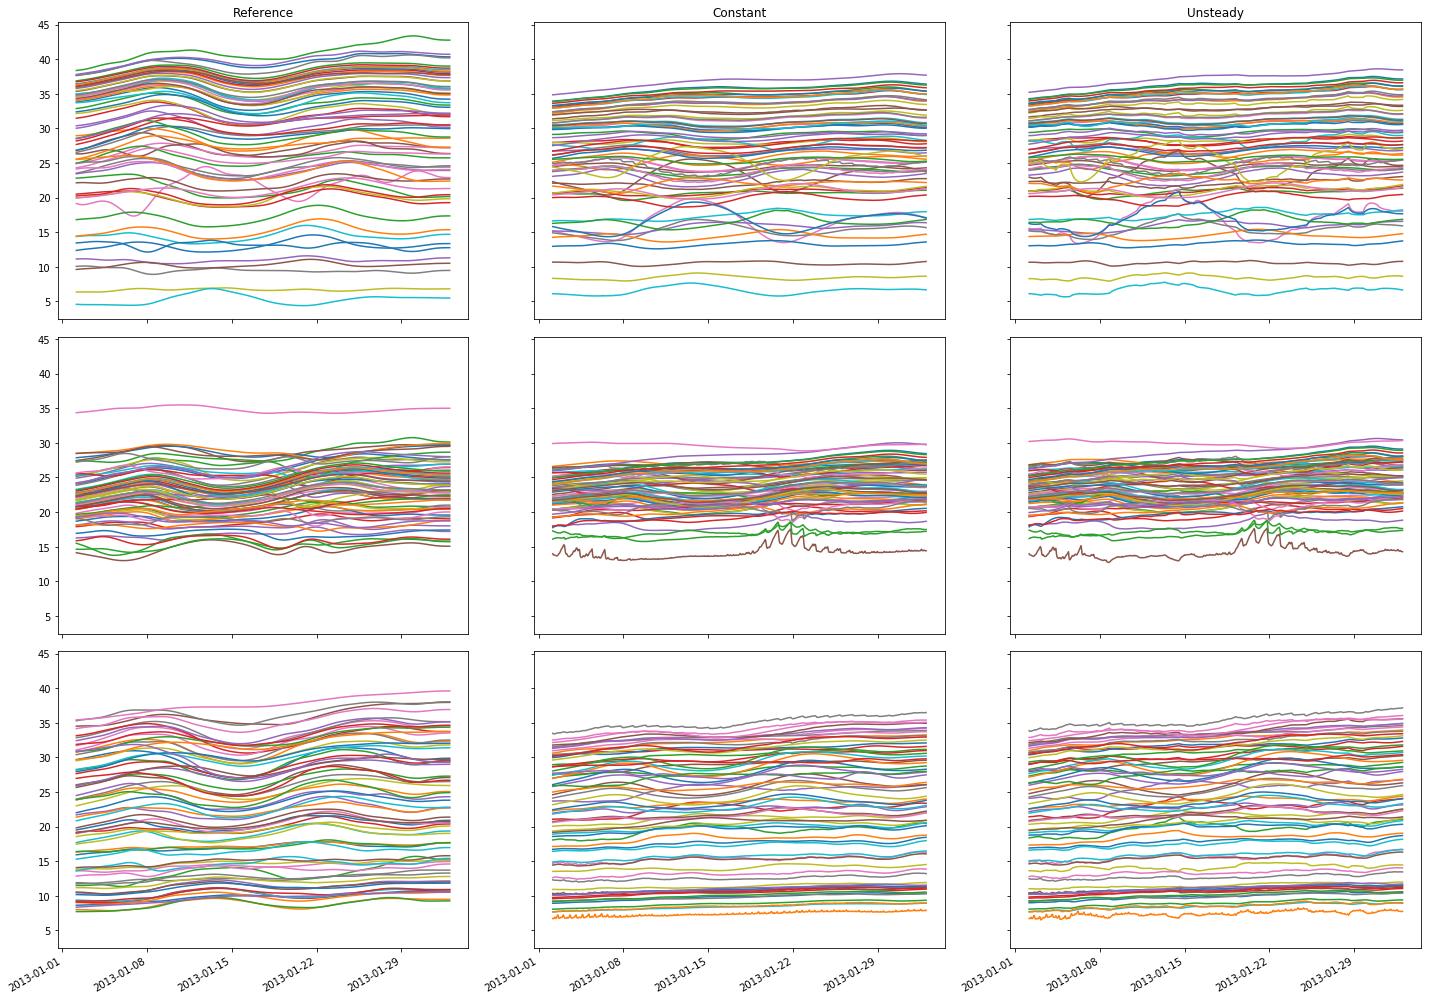

In [318]:
fig,axs=plt.subplots(len(ages),1+len(tracers),sharex=True,sharey=True,figsize=(20,14))

styles=['--',':']

ref_ds=orig_tracers

from stompy import filters

for ax_row,age in zip(axs,ages):
    ref_ages=ref_ds[age].isel(face=cell_sel)
    ref_lp=filters.lowpass(ref_ages.values,cutoff=36,dt=0.5,axis=0)
    ref_ages=ref_ds[age].isel(time=plot_t_slc,face=cell_sel)
        
    # ax_row[0].plot(ref_ages.time.values,ref_ages.values,alpha=0.1)
    ax_row[0].plot(ref_ages.time.values,ref_lp[plot_t_slc])
    
    for ax,test_ds in zip(ax_row[1:],tracers):
        test_ages=test_ds[age].isel(time=plot_t_slc,face=cell_sel)
        ax.plot(test_ages.time,test_ages.values)

axs[0,0].set_title('Reference')
axs[0,1].set_title('Constant')
axs[0,2].set_title('Unsteady')
fig.autofmt_xdate()
fig.tight_layout()

In [276]:
# How much variation is actually being created in K
g=run_const.hydro.grid()

K_runs=[#run_const,
        run_var,run_amp]
Ks=[run.disp_array() for run in K_runs]

INFO:utils:20046/20449
INFO:root:Median dispersion coefficient: 24.916
INFO:root:Median dispersion coefficient: 1.00274


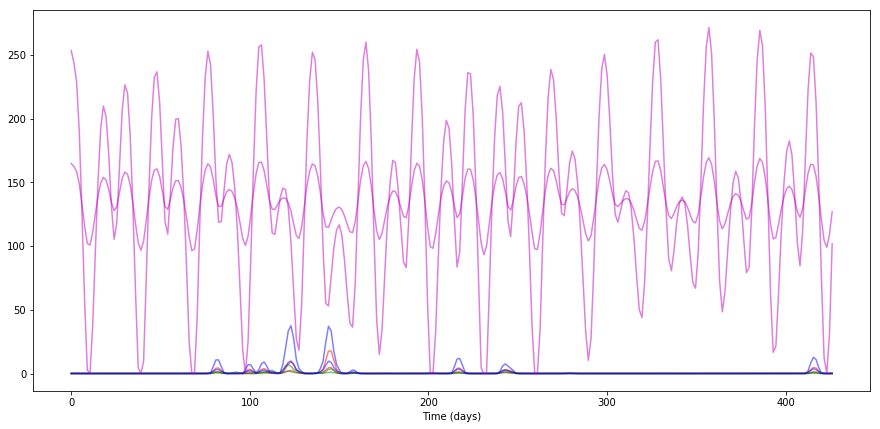

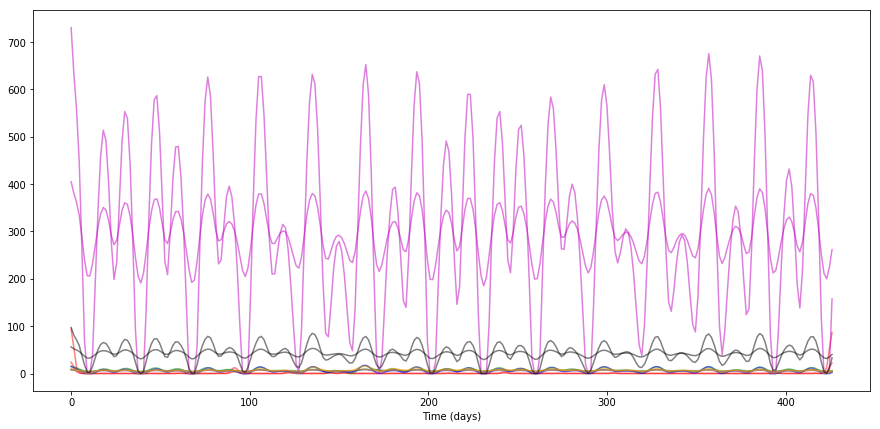

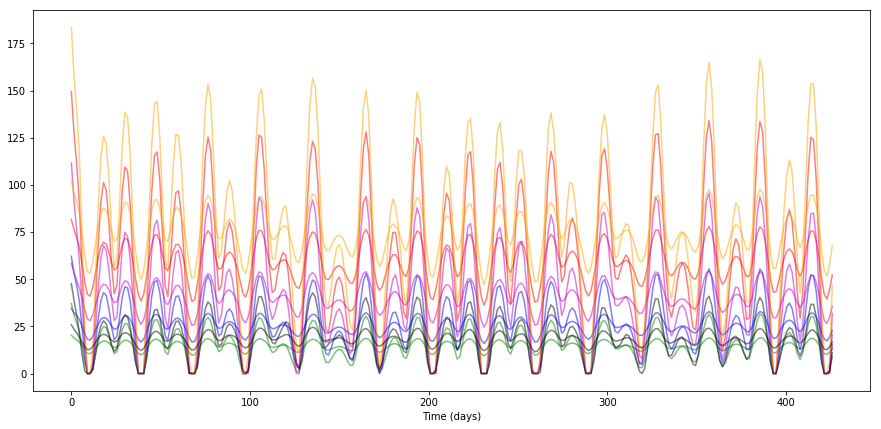

In [277]:
colors=['r','g','b','m','orange','k']

for pnt in DecayingPlume.X0:
    plt.figure(figsize=(15,7))
    c=g.select_cells_nearest(pnt)
    for j,color in zip(g.cell_to_edges(c),colors):
        # print(j)
        exch=np.nonzero( j==run.hydro.exch_to_2d_link['link'] )[0][0]
        for K,run in zip(Ks,K_runs):
            if isinstance( run, KautoUnsteady ):
                Ktime,Kvals=K
                Kvals=Kvals[...,exch]
                plt.plot(Ktime/86400.,Kvals,color=color,alpha=0.5)
                # And a possible "amplified" version
                #ctr=Kvals.mean()
                #Kamp=ctr + (Kvals-ctr)*2
                #plt.plot(Ktime/86400.,Kamp,ls='--',color=color)
            else:
                Kvals=K[exch]
                plt.axhline(Kvals,color=color,alpha=0.5)
    plt.xlabel('Time (days)')